## Imports
### Se cargan todas las librerias a utilizar

In [1]:
import pathlib

In [2]:
# Data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import skew, skewtest

In [3]:
# Charting
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
import seaborn as sns

In [4]:
# Deep Learning
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, MaxPool1D, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard

In [5]:
# OpenSees Py
import openseespy.opensees as op
import openseespy.postprocessing.ops_vis as opsv
import sympy as sp

#import the os module
import os
import math
from tabulate import tabulate

import scipy.linalg
import socket, struct
import sys

## Preprocessing functions
Esta función es utilizada para generar las base de datos de entrenamiento y testeo a utilizar

In [6]:
def walk_forward(df, x_labels, y_labels, n, n_input_labels, 
                 split_per=None, split_data=False, y_offset=0):
    
    td_shape = df.shape
    td_l = td_shape[0]
    
    x_indices = [range(i, i+n) for i in range(td_l-n)]
    y_indices = [range(i+y_offset, i+n) for i in range(td_l-n)]
    
    x = df.loc[:, x_labels].values[x_indices]
    y = df.loc[:, y_labels].values[y_indices]
    
    if split_data:
        split_index = int(len(x)*split_per)
        x = x.reshape(-1, n, n_input_labels, 1)
        y = y.reshape(-1, n-y_offset)
        X_train, X_test, y_train, y_test = (x[:split_index], x[split_index:], y[:split_index], y[split_index:])
        return X_train, X_test, y_train, y_test
    
    return x, y

## Generate Data
- A continuación, se resuelve un sistema lineal elástico cuyo input es la aceleración basal, la cual se genera de forma aleatoria.
- Se resuelve de esta forma ya que no tenemos los registros sísmicos para ser ingresados y esto funciona como un primer aproach

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 17 16:43:00 2021

@author: diego.mera
"""

##########################################################################################################################################################################
op.wipe()
#########################################################################################################################################################################
#All results in Inch, Kip and Sec
# Define ELEMENTS & SECTIONS 
inch = 1.0
kip = 1.0
sec = 1.0
LunitTXT = 'inch'
FunitTXT = 'kip'
TunitTXT = 'sec'
ft = 12*inch
ksi = kip/math.pow(inch,2)
psi = ksi/1000
lbf = psi*inch*inch
pcf = lbf/math.pow(ft,3)
inch2 = inch*inch
inch4 = math.pow(inch,4)
cm = inch/2.54
PI = 2 * math.asin(1.0)
g = 32.2 * ft/math.pow(sec,2)
Ubig = 1e10
Usmall = 1/Ubig


op.model('basic', '-ndm', 2, '-ndf', 3) 
LCol = 36.0*ft       # column length
LBeam = 42.0*ft      # beam length
Weight = 200.0*kip   # superstructure weight

# define section geometry
HCol = 5.0*ft   # Column Depth
BCol = 5.0*ft   # Column Width
HBeam = 8.0*ft  # Beam Depth
BBeam = 5.0*ft  # Beam Width

# calculated parameters
PCol =Weight/2  # nodal dead-load weight per column
g = 386.4       # Gravity in/s2
Mass =  PCol/g  # mass lb
MCol = ((Weight/LBeam)*math.pow(LBeam,2))/12

# calculated geometry parameters
ACol = HCol*BCol                        # cross-sectional area column
ABeam = HBeam*BBeam                     # cross-sectional area beam
IzCol = (BCol*math.pow(HCol,3))/12      # Column moment of inertia
IzBeam =  (BBeam*math.pow(HBeam,3))/12  # Beam moment of inertia


# Nodes
op.node(1, 0.0, 0.0)
op.node(2, LBeam, 0.0);
op.node(3, 2*LBeam, 0.0);
op.node(4, 0.0, LCol)
op.node(5, LBeam, LCol)
op.node(6, 2*LBeam, LCol)
op.node(7, 0.0, 2*LCol)
op.node(8, LBeam, 2*LCol)
op.node(9, 2*LBeam, 2*LCol)
op.node(10, 0.0, 3*LCol)
op.node(11, LBeam, 3*LCol)
op.node(12, 2*LBeam, 3*LCol)

# Create a homogeneous SP constriant.
op.fix(1, 1, 1, 0)
op.fix(2, 1, 1, 0); 
op.fix(3, 1, 1, 0); 

IDctrlNode = 2
IDctrlDOF = 1

# set the mass at a node
op.mass(4, Mass, 0.0, 0.0)
op.mass(5, Mass, 0.0, 0.0)
op.mass(6, Mass, 0.0, 0.0)
op.mass(7, Mass, 0.0, 0.0)
op.mass(8, Mass, 0.0, 0.0)
op.mass(9, Mass, 0.0, 0.0)
op.mass(10, Mass, 0.0, 0.0)
op.mass(11, Mass, 0.0, 0.0)
op.mass(12, Mass, 0.0, 0.0)

ColSecTag = 1			 # assign a tag number to the column section
BeamSecTag = 2           # assign a tag number to the beam section


seccion = 'Fibra' # Fibra or Agregaton

if seccion == 'Fibra':
    coverCol = 6.0*inch      # Column cover to reinforcing steel NA.
    numBarsCol = 10          # number of longitudinal-reinforcement bars in column. (symmetric top & bot)
    barAreaCol = 2.25*inch2  # area of longitudinal-reinforcement bars
    
    # MATERIAL parameters
    IDconcU = 1 			 # material ID tag -- unconfined cover concrete (here used for complete section)
    IDreinf = 2 			 # material ID tag -- reinforcement
    
    # nominal concrete compressive strength
    fc = -4.0*ksi 				   # CONCRETE Compressive Strength (+Tension, -Compression)
    Ec = 57*ksi*math.sqrt(-fc/psi) # Concrete Elastic Modulus (the term in sqr root needs to be in psi
    
    # unconfined concrete
    fc1U = fc			    # UNCONFINED concrete (todeschini parabolic model), maximum stress
    eps1U = -0.003			# strain at maximum strength of unconfined concrete
    fc2U =  0.2*fc1U		# ultimate stress
    eps2U = -0.05			# strain at ultimate stress
    Lambda = 0.1		    # ratio between unloading slope at $eps2 and initial slope $Ec
    
    # tensile-strength properties
    ftU = -0.14* fc1U		# tensile strength +tension
    Ets = ftU/0.002			# tension softening stiffness
    
    Fy = 66.8*ksi			# STEEL yield stress
    Es = 29000.0*ksi		# modulus of steel
    Bs = 0.01				# strain-hardening ratio 
    R0 = 18.0				# control the transition from elastic to plastic branches
    cR1 = 0.925				# control the transition from elastic to plastic branches
    cR2 = 0.15				# control the transition from elastic to plastic branches
    
    op.uniaxialMaterial('Concrete02', IDconcU, fc1U, eps1U, fc2U, eps2U, Lambda, ftU, Ets) # build cover concrete (unconfined)
    op.uniaxialMaterial('Steel02', IDreinf, Fy, Es, Bs, R0,cR1,cR2) # build reinforcement material
    # FIBER SECTION properties -------------------------------------------------------------
    # symmetric section
    #                        y
    #                        ^
    #                        |     
    #             ---------------------     --   --
    #             |   o     o     o    |     |    -- cover
    #             |                    |     |
    #             |                    |     |
    #    z <---   |          +         |     H
    #             |                    |     |
    #             |                    |     |
    #             |   o     o     o    |     |    -- cover
    #             ---------------------     --   --
    #             |-------- B --------|
    #
    # RC section: 
    coverY = HCol/2.0	# The distance from the section z-axis to the edge of the cover concrete -- outer edge of cover concrete
    coverZ = BCol/2.0	# The distance from the section y-axis to the edge of the cover concrete -- outer edge of cover concrete
    coreY = coverY-coverCol
    coreZ = coverZ-coverCol
    nfY = 16        # number of fibers for concrete in y-direction
    nfZ = 4			# number of fibers for concrete in z-direction
    
    op.section('Fiber', ColSecTag)
    op.patch('quad', IDconcU, nfZ, nfY, -coverY,coverZ, -coverY,-coverZ, coverY,-coverZ, coverY,coverZ) # Define the concrete patch
    op.layer('straight', IDreinf, numBarsCol, barAreaCol, -coreY,coreZ,-coreY,-coreZ)
    op.layer('straight', IDreinf, numBarsCol, barAreaCol, coreY,coreZ, coreY,-coreZ)
    
    # BEAM section:
    op.section('Elastic', BeamSecTag,Ec,ABeam,IzBeam)	# elastic beam section)

elif seccion == 'Agregator':
    #Define Elements and Sections
    ColMatTagFlex  = 2
    ColMatTagAxial = 3
    
    Fy = 66.8*ksi			# STEEL yield stress
    E0 = 29000.0*ksi		# modulus of steel
    Es = E0;
    b = 0.01
    R0=18.5
    cR1=0.925
    cR2=0.15
    params=[R0,cR1,cR2]
    a2 = 1.0
    a1=a2*Fy/E0
    a4 = 1.0
    a3=a4*Fy/E0
    
    op.uniaxialMaterial('Steel02', ColMatTagFlex, Fy, E0, b, R0, cR1, cR2, a1, a2, a3, a4) #steel moment curvature isused for Mz of the section only, # bilinear behavior for flexure
    op.uniaxialMaterial('Elastic', ColMatTagAxial, E0) # this is not used as a material, this is an axial-force-strain response
    op.section('Aggregator', ColSecTag, ColMatTagAxial, 'P', ColMatTagFlex, 'Mz')  # combine axial and flexural behavior into one section (no P-M interaction here)

    # BEAM section:
    op.section('Elastic', BeamSecTag,E0,ABeam,IzBeam)	# elastic beam section)


ColTransfTag = 1
BeamTransfTag = 2
op.geomTransf('Linear', ColTransfTag)
op.geomTransf('Linear', BeamTransfTag)

numIntgrPts = 5

IntegTagCol = 1
IntegTagBeam = 2

# We are using gauss-Legendre  integration as it is the default integration scheme used in opensees tcl
op.beamIntegration('Legendre', IntegTagCol , ColSecTag, 3)  
op.beamIntegration('Legendre', IntegTagBeam , BeamSecTag, 3)

# Select the section Type
sectiontype = 'elastic' # elastic - nonlinear - disp - force

if sectiontype == 'nonlinear':
    # columns
    op.element('nonlinearBeamColumn', 1, 1, 4, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 2, 2, 5, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 3, 4, 7, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 4, 5, 8, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 5, 6, 9, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 6, 7, 10, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 7, 8, 11, numIntgrPts, ColSecTag, ColTransfTag)
    op.element('nonlinearBeamColumn', 8, 9, 12, numIntgrPts, ColSecTag, ColTransfTag)
    
    op.element('nonlinearBeamColumn', 15, 3, 6, numIntgrPts, ColSecTag, ColTransfTag)
    # beam
    op.element('nonlinearBeamColumn', 9, 4, 5, numIntgrPts, BeamSecTag, BeamTransfTag)
    op.element('nonlinearBeamColumn', 10, 5, 6, numIntgrPts, BeamSecTag, BeamTransfTag)
    op.element('nonlinearBeamColumn', 11, 7, 8, numIntgrPts, BeamSecTag, BeamTransfTag)
    op.element('nonlinearBeamColumn', 12, 8, 9, numIntgrPts, BeamSecTag, BeamTransfTag)
    op.element('nonlinearBeamColumn', 13, 10, 11, numIntgrPts, BeamSecTag, BeamTransfTag)
    op.element('nonlinearBeamColumn', 14, 11, 12, numIntgrPts, BeamSecTag, BeamTransfTag)
    
elif sectiontype == 'disp':
    # columns
    op.element('dispBeamColumn', 1, 1, 4, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 2, 2, 5, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 3, 4, 7, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 4, 5, 8, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 5, 6, 9, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 6, 7, 10, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 7, 8, 11, ColTransfTag, IntegTagCol)
    op.element('dispBeamColumn', 8, 9, 12, ColTransfTag, IntegTagCol)
    
    op.element('dispBeamColumn', 15, 3, 6, ColTransfTag, IntegTagCol)
    # beam
    op.element('dispBeamColumn', 9, 4, 5, BeamTransfTag, IntegTagBeam)
    op.element('dispBeamColumn', 10, 5, 6, BeamTransfTag, IntegTagBeam)
    op.element('dispBeamColumn', 11, 7, 8, BeamTransfTag, IntegTagBeam)
    op.element('dispBeamColumn', 12, 8, 9, BeamTransfTag, IntegTagBeam)
    op.element('dispBeamColumn', 13, 10, 11, BeamTransfTag, IntegTagBeam)
    op.element('dispBeamColumn', 14, 11, 12, BeamTransfTag, IntegTagBeam)
    
elif sectiontype == 'force':
    # columns
    # op.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12, '-mass', mass=0.0)
    op.element('forceBeamColumn', 1, 1, 4, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 2, 2, 5, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 3, 4, 7, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 4, 5, 8, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 5, 6, 9, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 6, 7, 10, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 7, 8, 11, ColTransfTag, IntegTagCol)
    op.element('forceBeamColumn', 8, 9, 12, ColTransfTag, IntegTagCol)
    
    op.element('forceBeamColumn', 15, 3, 6, ColTransfTag, IntegTagCol)
    # beam
    op.element('forceBeamColumn', 9, 4, 5, BeamTransfTag, IntegTagBeam)
    op.element('forceBeamColumn', 10, 5, 6, BeamTransfTag, IntegTagBeam)
    op.element('forceBeamColumn', 11, 7, 8, BeamTransfTag, IntegTagBeam)
    op.element('forceBeamColumn', 12, 8, 9, BeamTransfTag, IntegTagBeam)
    op.element('forceBeamColumn', 13, 10, 11, BeamTransfTag, IntegTagBeam)
    op.element('forceBeamColumn', 14, 11, 12, BeamTransfTag, IntegTagBeam)
elif sectiontype == 'elastic':
    # columns
    op.element('elasticBeamColumn', 1, 1, 4, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 2, 2, 5, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 3, 4, 7, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 4, 5, 8, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 5, 6, 9, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 6, 7, 10, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 7, 8, 11, ACol, Es, IzCol, ColTransfTag)
    op.element('elasticBeamColumn', 8, 9, 12, ACol, Es, IzCol, ColTransfTag)
    
    op.element('elasticBeamColumn', 15, 3, 6, ACol, Es, IzCol, ColTransfTag)
    # beam
    op.element('elasticBeamColumn', 9, 4, 5, ABeam, Es, IzBeam, BeamTransfTag)
    op.element('elasticBeamColumn', 10, 5, 6, ABeam, Es, IzBeam, BeamTransfTag)
    op.element('elasticBeamColumn', 11, 7, 8, ABeam, Es, IzBeam, BeamTransfTag)
    op.element('elasticBeamColumn', 12, 8, 9, ABeam, Es, IzBeam, BeamTransfTag)
    op.element('elasticBeamColumn', 13, 10, 11, ABeam, Es, IzBeam, BeamTransfTag)
    op.element('elasticBeamColumn', 14, 11, 12, ABeam, Es, IzBeam, BeamTransfTag)
else:
    print('Undefined section')


#defining gravity loads
WzBeam = Weight/LBeam
op.timeSeries('Linear', 1)
op.pattern('Plain', 1, 1)
op.eleLoad('-ele', [9, 10, 11, 12, 13, 14], '-type', '-beamUniform', -WzBeam, 0.0, 0.0)
Tol = 1e-8                       # convergence tolerance for test
op.integrator('LoadControl', 1)  # determine the next time step for an analysis
op.numberer('Plain')             # renumber dof's to minimize band-width (optimization), if you want to
op.system('BandGeneral')         # how to store and solve the system of equations in the analysis
op.constraints('Plain')          # how it handles boundary conditions
op.test('NormDispIncr', Tol, 6)  # determine if convergence has been achieved at the end of an iteration step
op.algorithm('Newton')           # use Newton's solution algorithm: updates tangent stiffness at every iteration
op.analysis('Static')            # define type of analysis static or transient
op.analyze(1)                    # apply gravity

op.loadConst('-time', 0.0)       # maintain constant gravity loads and reset time to zero


#%%   SEISMIC RECORD APPLIED IN A FOR LOOP
op.wipeAnalysis()

#applying Dynamic Ground motion analysis
Tol = 1e-3
maxNumIter = 10
GMdirection = 1
GMfact = 1.5
GMfatt = g*GMfact

Lambda = op.eigen('-fullGenLapack', 9) # eigenvalue mode 1
Omega = math.pow(Lambda[0], 0.5)
omega = np.sqrt(Lambda)
period = 2.0*np.pi/omega
freq = 1/period
betaKcomm = 2 * (0.02/Omega)

Damping = 'Modal' # Modal - Rayleigh

if Damping == 'Rayleigh':
    xDamp = 0.05				                        # 5% damping ratio
    alphaM = 0.0				                        # M-prop. damping; D = alphaM*M	
    betaKcurr = 0.0		                                # K-proportional damping;      +beatKcurr*KCurrent
    betaKinit = 0.0                                     # initial-stiffness proportional damping      +beatKinit*Kini
    op.rayleigh(alphaM,betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping
elif Damping == 'Modal':    
    zeta = 0.05
    op.modalDamping(zeta) # Modal Damping
else:
    print('Unspecified damping')

    
    
import scipy.io
excitation = scipy.io.loadmat('excitation.mat')
register = np.transpose(excitation['exc'][::1])
Lista = []
for i in range(register.shape[0]):
    Lista.extend(register[i])
register = np.array(np.transpose(Lista))
time_steps = register.shape[0]   
    
#time_steps = 120000
#register = 0.25 * (np.random.rand(time_steps) - 0.5)
dt = 0.02




i=1
motion = register[0:-1]
values = list(-1 * motion)  # should be negative
op.timeSeries('Path', i+20000, '-dt', dt, '-values', *values, '-factor', GMfatt)
IDloadTag = i+4000		# load tag
op.pattern('UniformExcitation', IDloadTag, GMdirection, '-accel', i+20000)

index = list(np.linspace(0, (len(motion)-1)*dt, len(motion)))

time2 = [0.0]

u44 = [0.0]
u77= [0.0]

okk = 0

op.constraints('Transformation')
op.numberer('Plain')
op.system('BandGeneral')
op.test('EnergyIncr', Tol, maxNumIter)
op.algorithm('Linear')
op.integrator('AlphaOS',0.9)
op.analysis('Transient')

for i in range(0,time_steps-1):     
    okk = op.analyze(1, dt)  
    if okk == 0 :
        tCurrent = dt*i              
        time2.append(tCurrent)
        u44.append(op.nodeDisp(4,1))
        u77.append(op.nodeDisp(7,1))

In [13]:
# Displat Period and Frequency of the model
d = [ ["Mode 1", period[0], freq[0]],
      ["Mode 2", period[1], freq[1]],
      ["Mode 3", period[2], freq[2]],
      ["Mode 4", period[3], freq[3]],
      ["Mode 5", period[4], freq[4]],
      ["Mode 6", period[5], freq[5]],
      ["Mode 7", period[6], freq[6]],
      ["Mode 8", period[7], freq[7]],
      ["Mode 9", period[8], freq[8]]]

print(tabulate(d, headers=["Mode", "Period [s]", "Frequency [Hz]"]))

Mode      Period [s]    Frequency [Hz]
------  ------------  ----------------
Mode 1    0.194866             5.13173
Mode 2    0.0504181           19.8341
Mode 3    0.0281166           35.5662
Mode 4    0.00555031         180.17
Mode 5    0.00552443         181.014
Mode 6    0.00545223         183.411
Mode 7    0.00320521         311.992
Mode 8    0.0032             312.5
Mode 9    0.00318628         313.846


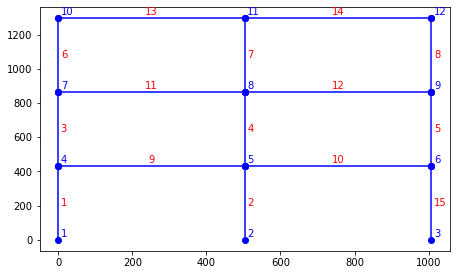

In [14]:
# 1. plot model with tag lebels
opsv.plot_model()
plt.show()
op.wipe()

In [15]:
d = {'exc': register, 'disp': u44}
gen_data = pd.DataFrame(data=d)
gen_data.head()

,exc,disp
0,0.000000,0.000000
1,-0.008678,-0.000432
2,-0.008670,-0.001764
3,-0.008663,-0.003683
4,-0.008659,-0.005487


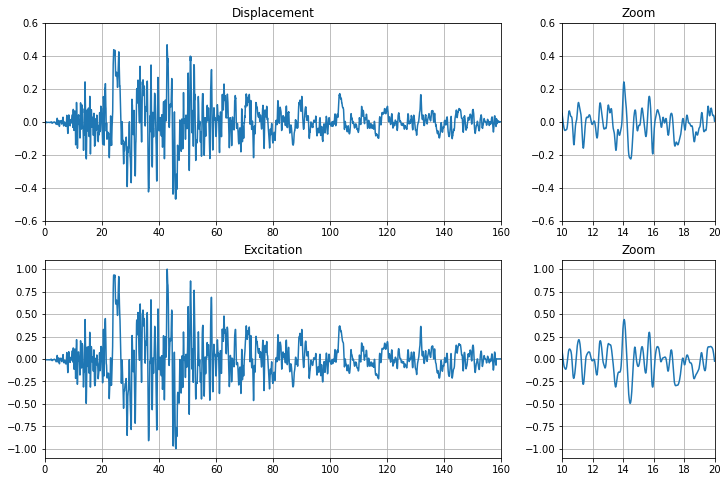

In [17]:
x = gen_data['disp']
a = gen_data['exc']
t = np.linspace(0,dt*time_steps,time_steps)

fig = plt.figure(figsize=(12, 8)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 

ax0 = plt.subplot(gs[0])
ax0.plot(t, x)
ax0.set_xlim([0, 160])
ax0.title.set_text('Displacement')
ax0.set_ylim([-0.6,0.6])
ax0.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(t, x)
ax1.set_xlim([10,20])
ax1.title.set_text('Zoom')
ax1.set_ylim([-0.6,0.6])
ax1.grid()

ax2 = plt.subplot(gs[2])
ax2.plot(t, a)
ax2.set_xlim([0,160])
ax2.title.set_text('Excitation')
ax2.set_ylim([-1.1,1.1])
ax2.grid()

ax3 = plt.subplot(gs[3])
ax3.plot(t, a)
ax3.set_xlim([10,20])
ax3.title.set_text('Zoom')
ax3.set_ylim([-1.1,1.1])
ax3.grid()

plt.show()

In [18]:
for col in gen_data.columns:
    mean = gen_data[col].mean()
    minimum = gen_data[col].min()
    maximum = gen_data[col].max()
    gen_data[col] = (gen_data[col]-mean)/(maximum - minimum)
    gen_data[col] = gen_data[col] / 2.0 + 0.5

## Preprocessing

In [21]:
n = 100

In [22]:
train_df = gen_data.iloc[:200000, :]
delayed_disp = train_df['disp'][:len(train_df)-n].rename('del_disp')
train_df = train_df.iloc[n:, :].reset_index(drop=True).join(delayed_disp)
train_df.head(105)

,exc,disp,del_disp
0,0.498362,0.498996,0.500027
1,0.498502,0.499096,0.499888
2,0.498689,0.499199,0.499459
3,0.498863,0.499303,0.498840
4,0.499022,0.499407,0.498259
...,...,...,...
100,0.492884,0.495776,0.498996
101,0.493220,0.496147,0.499096
102,0.493719,0.496447,0.499199
103,0.494469,0.496687,0.499303


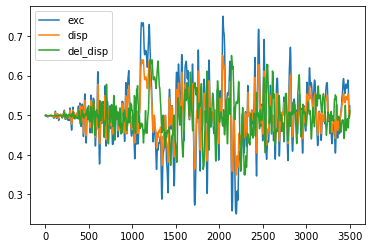

In [23]:
train_df.loc[:3500, :].plot()
plt.show()

### Some config params

In [24]:
td_shape = train_df.shape
td_l = td_shape[0]

In [25]:
x_labels = ['exc', 'del_disp']
y_labels = ['disp']

In [26]:
n_input_labels = len(x_labels)
y_offset = 1

In [27]:
train_percentage = 0.8 # porcentaje de la base de datos que será utilizado como entrenamiento.
length_train_data = len(train_df)
split_index = int(length_train_data*train_percentage)

In [28]:
split_index

159920

## Get train and test data

### Walk forward
Las bases de datos de entrenamiento y testeo son reorganizadas. Como se aprecio previamente se resolve el sistema dinámico de forma tal que se obtiene una base de datos con inputs y outputs. El reordenamiento es para generar un conjunto de datos de input/output pero múltiple. Así se obtienen varios registros (series temporales) de input/output para entrenamiento y testeo y no una única serie temporal.

In [29]:
X_train, X_test, y_train, y_test = walk_forward(train_df, 
                                                x_labels, y_labels, 
                                                n, n_input_labels, y_offset=y_offset,
                                                split_per=0.7, split_data=True)

X_train = X_train.reshape(-1, n, n_input_labels, 1)
y_train = y_train.reshape(-1, n-y_offset)

## Model
A continuación, se define el modelo de la Red Neuronal

In [30]:
tb_callback = TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True)

In [31]:
class Model():

    def __init__(self):
        self.mdl = None
        self.hist = None

    def create_model(self, input_shape, n_outputs):

        # Optimiser
        opt = Adam(learning_rate=0.001)

        # define model
        self.mdl = Sequential()
        
        self.mdl.add(Conv2D(9, (2,1), input_shape=input_shape))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())
        
        self.mdl.add(Flatten())
        self.mdl.add(Dense(200, activation='relu'))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())
        
        self.mdl.add(Dense(n_outputs))
        
        # Prepare model for training
        self.mdl.compile(loss='mae',
                      optimizer=opt,
                      metrics=['mse'])


    def run_model(self, X_train, X_test, y_train, y_test, callback):

        # Fit model
        self.hist = self.mdl.fit(X_train, y_train,
                                batch_size=1000,
                                epochs=30,
                                verbose=True,
                                validation_data=(X_test, y_test),
                                callbacks=[callback])

In [32]:
# Create Model
model = Model()
model.create_model(X_train[0].shape, n-y_offset)

C:\Users\diego.mera\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Sumarry
Keras proporciona una forma de resumir un modelo.El resumen es textual e incluye información sobre:
- Las capas y su orden en el modelo.
- La forma de salida de cada capa.
- El número de parámetros (pesos) en cada capa.
- El número total de parámetros (pesos) en el modelo.

In [33]:
model.mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 2, 9)          27        
                                                                 
 dropout (Dropout)           (None, 99, 2, 9)          0         
                                                                 
 batch_normalization (BatchN  (None, 99, 2, 9)         36        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 1782)              0         
                                                                 
 dense (Dense)               (None, 200)               356600    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                        

- Una vez creado el modelo, se puede configurar el modelo con pérdidas y métricas con model.compile(), entrenar el modelo con model.fit() o usar el modelo para hacer predicciones model.predict().

In [34]:
model.run_model(X_train, X_test, y_train, y_test, tb_callback)

Epoch 1/30
140/140 [==============================] - 15s 94ms/step - loss: 0.3656 - mse: 0.3747 - val_loss: 0.0222 - val_mse: 0.0010
Epoch 2/30
140/140 [==============================] - 13s 93ms/step - loss: 0.0337 - mse: 0.0249 - val_loss: 0.0258 - val_mse: 0.0012
Epoch 3/30
140/140 [==============================] - 13s 90ms/step - loss: 0.0112 - mse: 3.9139e-04 - val_loss: 0.0172 - val_mse: 6.5404e-04
Epoch 4/30
140/140 [==============================] - 13s 91ms/step - loss: 0.0096 - mse: 3.1336e-04 - val_loss: 0.0132 - val_mse: 4.0527e-04
Epoch 5/30
140/140 [==============================] - 13s 90ms/step - loss: 0.0093 - mse: 3.0144e-04 - val_loss: 0.0094 - val_mse: 2.0998e-04
Epoch 6/30
140/140 [==============================] - 13s 93ms/step - loss: 0.0092 - mse: 3.0018e-04 - val_loss: 0.0071 - val_mse: 1.2329e-04
Epoch 7/30
140/140 [==============================] - 13s 94ms/step - loss: 0.0092 - mse: 2.9815e-04 - val_loss: 0.0060 - val_mse: 9.4556e-05
Epoch 8/30
140/140 [==

## Evaluation

                  0
count  5.934060e+06
mean  -4.054968e-03
std    9.472845e-03
min   -1.375359e-01
25%   -7.160820e-03
50%   -4.141011e-03
75%   -8.865828e-04
max    1.123547e-01


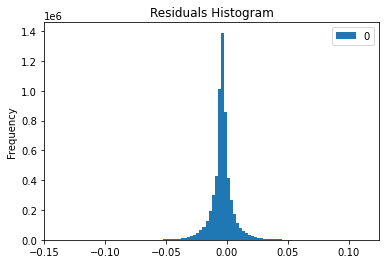

In [35]:
# Gráfico de error (%)
# Histograma de la diferencia entre el valor predecido y el de testeo.
preds = model.mdl.predict(X_test)
resids_all = preds-y_test
resids = pd.DataFrame((preds - y_test).reshape(-1))
resids.plot(kind='hist', bins=100, title='Residuals Histogram')
print(resids.describe())

Statistics=119104.654, p=0.000
La muestra no parece gaussiana (rechazar H0)


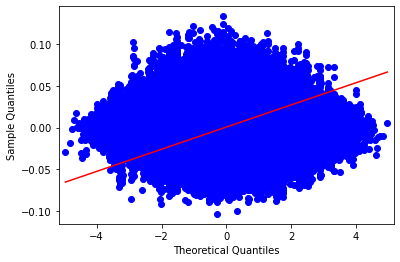

In [30]:
# Test D'Agostino u Pearson's
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest

# Observaciones
data = resids.values

# Test de normalidad
stat, p = normaltest(data)

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpretar
alpha = 0.05
if p > alpha:
    print('La muestra parece gaussiana (no rechaza H0)')
else:
    print('La muestra no parece gaussiana (rechazar H0)')
    
# q-q plot
qqplot(data, line='s')
pyplot.show()

- Al ejecutar, se crea el gráfico QQ que muestra el gráfico de dispersión de puntos como una nube de puntos, que no se ajusta al patrón diagonal esperado para una muestra de una distribución gaussiana.

In [36]:
# Devuelve el valor de pérdida y los valores de las métricas del modelo en modo de prueba.
names = model.mdl.metrics_names
value = model.mdl.evaluate(X_test, y_test, verbose=0)

print('\nMetricas:\n ')
print(names[0],': ',value[0])
print(names[1],': ',value[1])
print('r2 Score:   ',r2_score(y_test, preds))
print("")


Metricas:
 
loss :  0.0072527979500591755
mse :  0.00010617761290632188
r2 Score:    0.8847122959986324



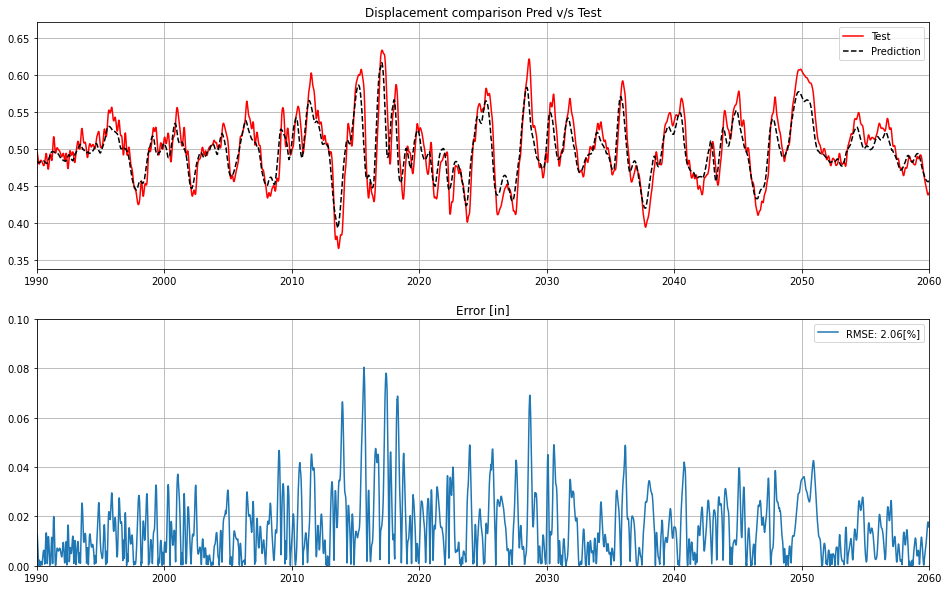

In [51]:
l1 = 1990
l2 = 2060

a = np.transpose(preds)
pred = a.reshape(-1)

c = np.transpose(y_test)
testeo = c.reshape(-1)

error = (abs(testeo-pred))

RMS = np.sqrt(np.mean((testeo-pred)**2))/np.sqrt(np.mean(testeo**2))*100

pasos = pred.shape[0]
t = np.linspace(0,dt*pasos,pasos)

fig = plt.figure(figsize=(16, 10)) 
gs = gridspec.GridSpec(2, 1) 

ax0 = plt.subplot(gs[0])
ax0.plot(t, testeo,'r',label="Test")
ax0.plot(t, pred,'k--',label="Prediction")
ax0.title.set_text('Displacement comparison Pred v/s Test')
ax0.legend(loc="upper right")
ax0.set_xlim([l1, l2])
ax0.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(t, error,label="RMSE: "+str(round(RMS,2))+"[%]")
ax1.title.set_text('Error [in]')
ax1.legend(loc="upper right")
ax1.set_xlim([l1, l2])
ax1.set_ylim([0, 0.1])
ax1.grid()

plt.show()

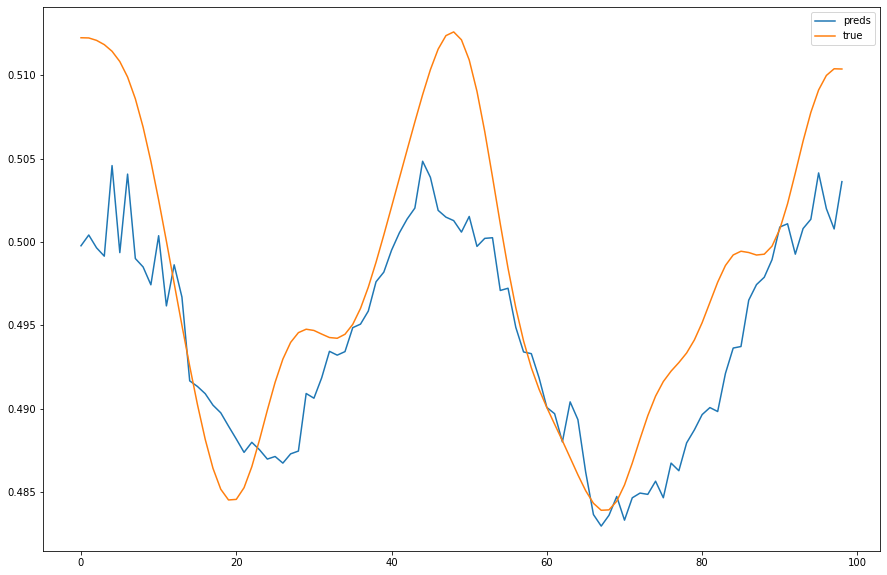

In [37]:
comp_ind = 2000
comparison = pd.concat([pd.DataFrame(preds[comp_ind].reshape(-1), columns=['preds']), 
                        pd.DataFrame(y_test[comp_ind].reshape(-1), columns=['true'])], axis=1)
comparison.plot(figsize=(15,10))
plt.show()

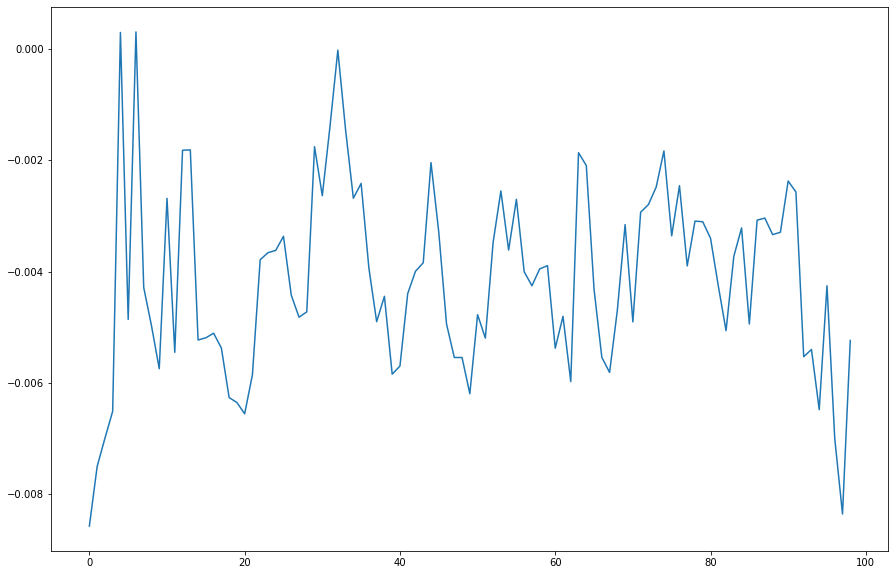

In [38]:
indices = np.random.randint(low=0, high=len(resids_all), size=1)
pd.DataFrame((resids_all[indices])).T.plot(figsize=(15,10), legend=False)
plt.show()

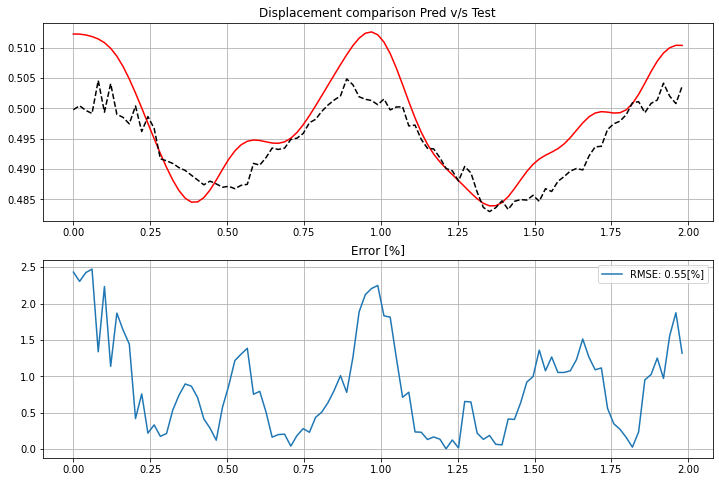

In [39]:
pred = preds[comp_ind]
testeo = y_test[comp_ind]
error = abs((testeo-pred)/max(abs(testeo))*100)
RMSE = mean_squared_error(testeo, pred, squared=False)

pasos = preds[comp_ind].shape[0]
t = np.linspace(0,dt*pasos,pasos)

fig = plt.figure(figsize=(12, 8)) 
gs = gridspec.GridSpec(2, 1) 

ax0 = plt.subplot(gs[0])
ax0.plot(t, testeo,'r',label="Test")
ax0.plot(t, pred,'k--',label="Prediction")
ax0.title.set_text('Displacement comparison Pred v/s Test')
ax0.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(t, error,label="RMSE: "+str(round(RMSE*100,2))+"[%]")
ax1.title.set_text('Error [%]')
ax1.grid()

plt.legend() 
plt.show()